<a href="https://colab.research.google.com/github/kangnurrohman/word-vector/blob/main/src/Part%204%20-%20Sentiment%20Analysis%20with%20FastText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import zipfile
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/data/data 6.zip", 'r')
# zip_ref.extractall("data")
# zip_ref.close()

In [6]:
# pip install jcopml

In [10]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [11]:
#import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
#nltk.download('stopwords')
#nltk.download('punkt')

In [12]:
sw_indo = stopwords.words("indonesian") + list(punctuation)

## Import Data

In [13]:
df = pd.read_csv("../../data/gojek_review_sentiment.csv")
df.head()

,review,rate
0,Apa aplikasi yang bagus untuk dengan mudah per...,positive
1,Aplikasi ini banyak membantu saya. Sekarang sa...,positive
2,Mengerikan. Antarmukanya sangat membingungkan....,negative
3,Aplikasi yang cukup mengesankan. Butuh waktu l...,positive
4,Aplikasi ini sebenarnya bagus dan sangat memba...,positive


In [14]:
df.rate.value_counts(normalize=True)

negative    0.595398
positive    0.404602
Name: rate, dtype: float64

## Encoding

In [15]:
from gensim.models import FastText

In [16]:
w2v = FastText.load("../../data/model/fasttext/gojek_review.fasttext").wv

In [17]:
def sent_vector(sentence, w2v_model, stopwords):
  vecs = [w2v_model[word.lower()] for word in word_tokenize(sentence) if word not in stopwords]
  sent_vec = np.mean(vecs, axis=0)
  return sent_vec

def norm_sent_vector(sentence, w2v_model, stopwords):
  vecs = [w2v_model[word.lower()] for word in word_tokenize(sentence) if word not in stopwords]
  norm_vecs = [vec / np.linalg.norm(vec) for vec in vecs if np.linalg.norm(vec) > 0]
  sent_vec = np.mean(norm_vecs, axis=0)
  return sent_vec

In [18]:
vecs = [sent_vector(sentence, w2v, sw_indo) for sentence in df.review]
vecs = np.array(vecs)
vecs

array([[-1.3797743e-02, -3.7794587e-01, -4.5372140e-01, ...,
         4.8197597e-02,  4.9815816e-01, -3.0808460e-02],
       [ 5.7671353e-02, -2.3767716e-01, -2.3528852e-01, ...,
         2.1159397e-01,  7.4173772e-01, -8.3569892e-02],
       [-1.4525014e-01,  5.2495480e-02, -2.0636749e-01, ...,
        -1.0901792e-01,  3.3448571e-01, -1.5521082e-01],
       ...,
       [ 6.6199794e-02, -3.1072897e-01,  1.3862197e-01, ...,
        -6.7783415e-02,  5.6665707e-01, -3.2514340e-01],
       [-3.3561934e-02, -6.1295398e-02, -5.0850421e-01, ...,
         1.3629022e-01,  8.8104075e-01, -1.6323066e-01],
       [-4.4231117e-04, -7.4599206e-02, -1.0312299e-01, ...,
         3.7486777e-03,  1.9106190e-01,  8.2643338e-02]], dtype=float32)

In [19]:
vecs.shape

(1782, 128)

## Data Splitting

In [20]:
X = vecs
y = df.rate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1425, 128), (357, 128), (1425,), (357,))

## Training

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [22]:
pipeline = Pipeline([
    ('algo', SVC(max_iter=500))
])

model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=4,  n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 4 folds for each of 50 candidates, totalling 200 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 4.418441521199726, 'algo__gamma': 0.010547383621352041}
0.8989473684210526 0.8694646397884996 0.9019607843137255


## Evaluation

In [23]:
from jcopml.plot import plot_confusion_matrix

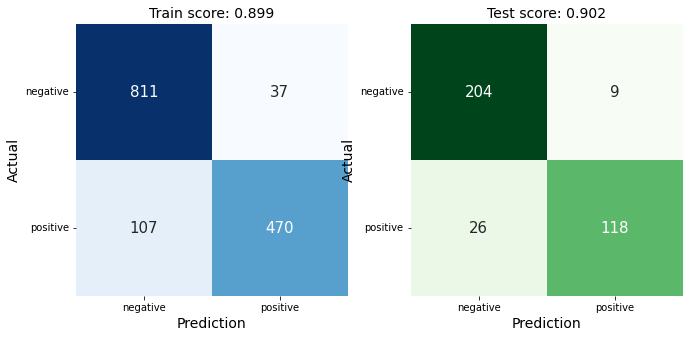

In [24]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)